In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import math
import random

random.seed(42)
np.random.seed(42)

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120


In [18]:
def generate_steel_dataset(n_samples=800, random_state=42):
    rng = np.random.RandomState(random_state)
    C = rng.uniform(0.05, 0.9, n_samples)
    Si = rng.uniform(0.1, 1.5, n_samples)
    Mn = rng.uniform(0.2, 2.0, n_samples)
    Cr = rng.uniform(0.0, 2.5, n_samples)
    Ni = rng.uniform(0.0, 2.0, n_samples)
    Mo = rng.uniform(0.0, 0.6, n_samples)
    austenitizing_temp = rng.uniform(820, 980, n_samples)
    austenitizing_time = rng.uniform(0.5, 2.5, n_samples)
    cooling_rate = rng.uniform(0.5, 200, n_samples)
    temper_temp = rng.choice([200, 350, 450, 600], size=n_samples, p=[0.25,0.3,0.3,0.15])
    grain_size = rng.uniform(2, 60, n_samples)

    sigma0 = 200.0
    comp_strength = 250*C + 20*Si + 15*Mn + 18*Cr + 12*Ni + 40*Mo
    k_hp = 400.0
    hall_petch = k_hp / np.sqrt(np.maximum(grain_size, 0.1))
    quench_effect = 120 * (1 / (1 + np.exp(-0.02*(cooling_rate-20))))
    temper_loss = np.where(temper_temp < 300, 0,
                           np.where(temper_temp < 400, 40,
                                    np.where(temper_temp < 500, 80, 140)))
    heat_effect = -0.08*(austenitizing_temp - 900) + 5*np.log1p(austenitizing_time)
    noise = rng.normal(0, 25, n_samples)
    UTS = sigma0 + comp_strength + hall_petch + quench_effect + heat_effect - temper_loss + noise
    UTS = np.clip(UTS, 100, 2000)

    df = pd.DataFrame({
        'C_wt%': np.round(C, 3),
        'Si_wt%': np.round(Si, 3),
        'Mn_wt%': np.round(Mn, 3),
        'Cr_wt%': np.round(Cr, 3),
        'Ni_wt%': np.round(Ni, 3),
        'Mo_wt%': np.round(Mo, 3),
        'AustenTemp_C': np.round(austenitizing_temp, 1),
        'AustenTime_hr': np.round(austenitizing_time, 3),
        'CoolingRate_Cps': np.round(cooling_rate, 3),
        'TemperTemp_C': temper_temp,
        'GrainSize_um': np.round(grain_size, 3),
        'UTS_MPa': np.round(UTS, 3)
    })
    return df

df = generate_steel_dataset(n_samples=800, random_state=42)
print("Rows:", df.shape[0])
df.head()


Rows: 800


,C_wt%,Si_wt%,Mn_wt%,Cr_wt%,Ni_wt%,Mo_wt%,AustenTemp_C,AustenTime_hr,CoolingRate_Cps,TemperTemp_C,GrainSize_um,UTS_MPa
0,0.368,1.090,0.545,0.852,1.107,0.343,839.8,1.036,137.000,350,43.776,483.133
1,0.858,0.314,0.782,0.179,1.006,0.483,831.3,1.131,176.547,200,41.862,674.572
2,0.672,0.907,0.608,1.024,0.388,0.456,965.5,0.751,41.100,350,7.554,618.395
3,0.559,0.949,0.839,0.778,1.718,0.092,850.4,1.811,174.736,200,55.509,586.979
4,0.183,0.694,0.325,1.693,1.354,0.090,951.4,0.580,12.423,600,34.971,317.953


,count,mean,std,min,25%,50%,75%,max
C_wt%,800.0,0.472417,0.249553,0.054,0.25550,0.4805,0.69025,0.900
Si_wt%,800.0,0.800154,0.410084,0.106,0.42925,0.8065,1.13550,1.499
Mn_wt%,800.0,1.098014,0.517302,0.203,0.65700,1.1160,1.54325,1.997
Cr_wt%,800.0,1.251026,0.727978,0.000,0.66375,1.2380,1.88600,2.495
Ni_wt%,800.0,0.982380,0.574590,0.001,0.46725,0.9710,1.49625,1.999
Mo_wt%,800.0,0.295606,0.171190,0.000,0.14875,0.3000,0.43800,0.599
AustenTemp_C,800.0,899.587750,46.000588,820.200,861.37500,897.3000,938.70000,979.800
AustenTime_hr,800.0,1.492277,0.579299,0.508,0.97950,1.4930,1.99625,2.499
CoolingRate_Cps,800.0,99.776787,57.828622,0.548,48.71125,97.6090,153.19125,199.842
TemperTemp_C,800.0,370.937500,130.402270,200.000,200.00000,350.0000,450.00000,600.000


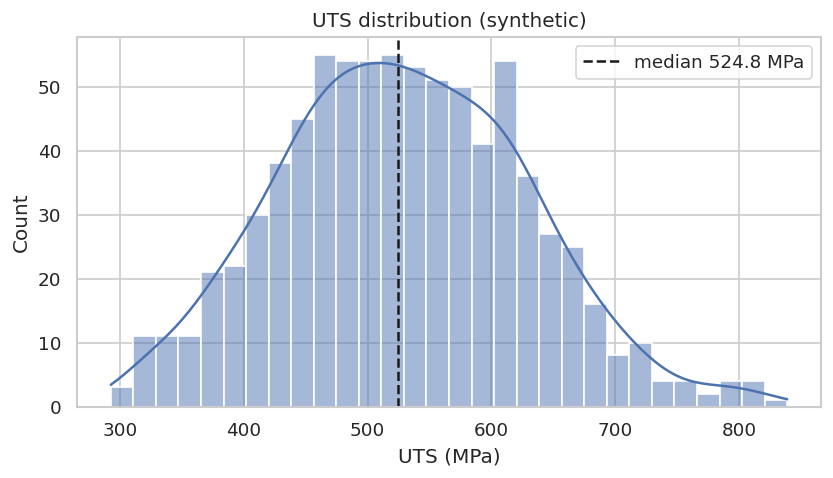

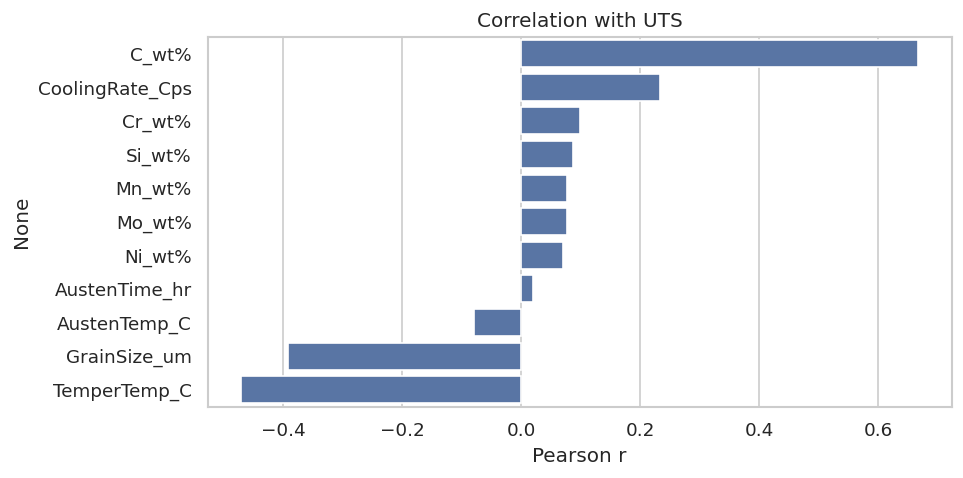

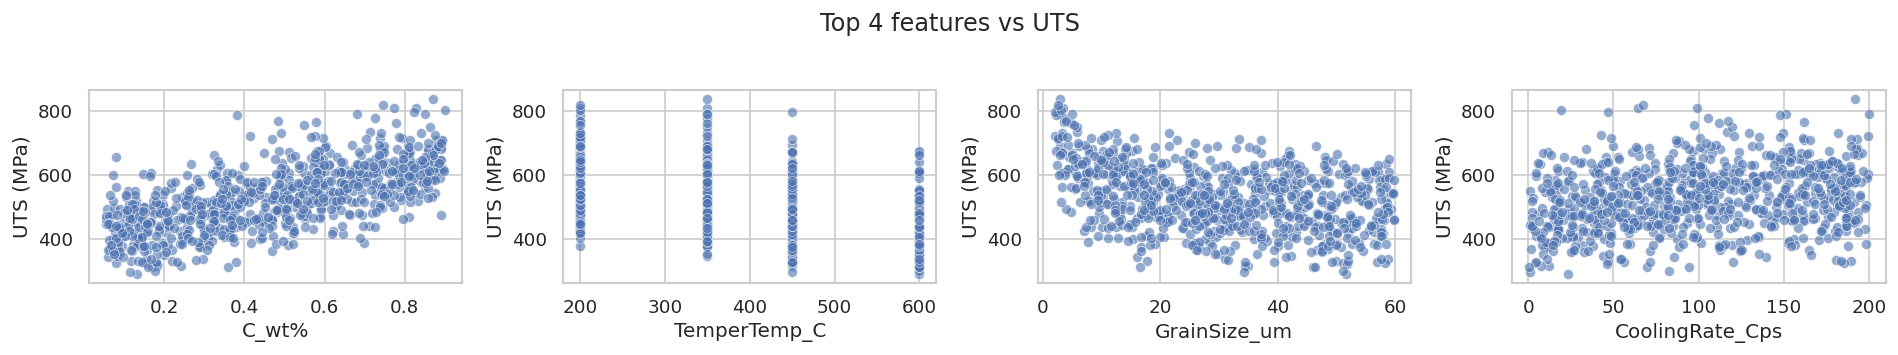

In [19]:
# summary
display(df.describe().T)

# UTS distribution
plt.figure(figsize=(8,4))
sns.histplot(df['UTS_MPa'], bins=30, kde=True)
plt.axvline(df['UTS_MPa'].median(), color='k', linestyle='--', label=f"median {df['UTS_MPa'].median():.1f} MPa")
plt.title("UTS distribution (synthetic)")
plt.xlabel("UTS (MPa)")
plt.legend()
plt.show()

# correlation with target (bar)
corr_with_target = df.corr()['UTS_MPa'].drop('UTS_MPa').sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title("Correlation with UTS")
plt.xlabel("Pearson r")
plt.show()

# scatter for top 4
top4 = corr_with_target.abs().sort_values(ascending=False).head(4).index.tolist()
fig, axes = plt.subplots(1,4, figsize=(16,3))
for ax, feat in zip(axes, top4):
    sns.scatterplot(x=df[feat], y=df['UTS_MPa'], alpha=0.6, ax=ax)
    ax.set_xlabel(feat)
    ax.set_ylabel('UTS (MPa)')
plt.suptitle("Top 4 features vs UTS")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [20]:
features = ['C_wt%', 'Si_wt%', 'Mn_wt%', 'Cr_wt%', 'Ni_wt%', 'Mo_wt%',
            'AustenTemp_C', 'AustenTime_hr', 'CoolingRate_Cps', 'TemperTemp_C', 'GrainSize_um']
target = 'UTS_MPa'

X = df[features].copy()
y = df[target].copy()
X = pd.get_dummies(X, columns=['TemperTemp_C'], prefix='Temp')

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler for linear model
scaler = StandardScaler()
numeric_cols = ['C_wt%','Si_wt%','Mn_wt%','Cr_wt%','Ni_wt%','Mo_wt%','AustenTemp_C','AustenTime_hr','CoolingRate_Cps','GrainSize_um']
X_train_scaled = X_train.copy()
X_train_scaled.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = X_test.copy()
X_test_scaled.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Feature shape:", X_train.shape)


Feature shape: (640, 14)


In [21]:
def print_regression_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true,y_pred)
    rmse = math.sqrt(mean_squared_error(y_true,y_pred))
    r2 = r2_score(y_true,y_pred)
    print(f"{name} -> MAE: {mae:.2f} MPa, RMSE: {rmse:.2f} MPa, R2: {r2:.3f}")


LinearRegression -> MAE: 28.02 MPa, RMSE: 36.24 MPa, R2: 0.863


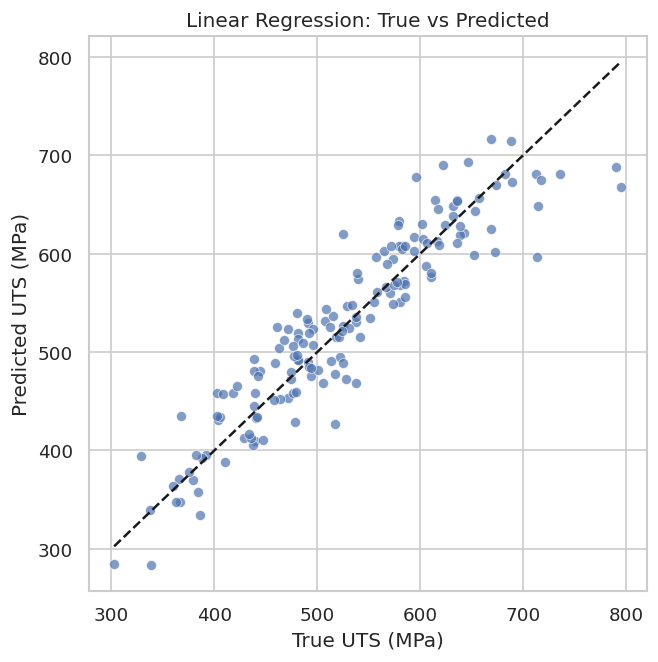

In [22]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print_regression_metrics(y_test, y_pred_lr, "LinearRegression")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True UTS (MPa)")
plt.ylabel("Predicted UTS (MPa)")
plt.title("Linear Regression: True vs Predicted")
plt.show()


RandomForest (default) -> MAE: 27.51 MPa, RMSE: 34.71 MPa, R2: 0.875


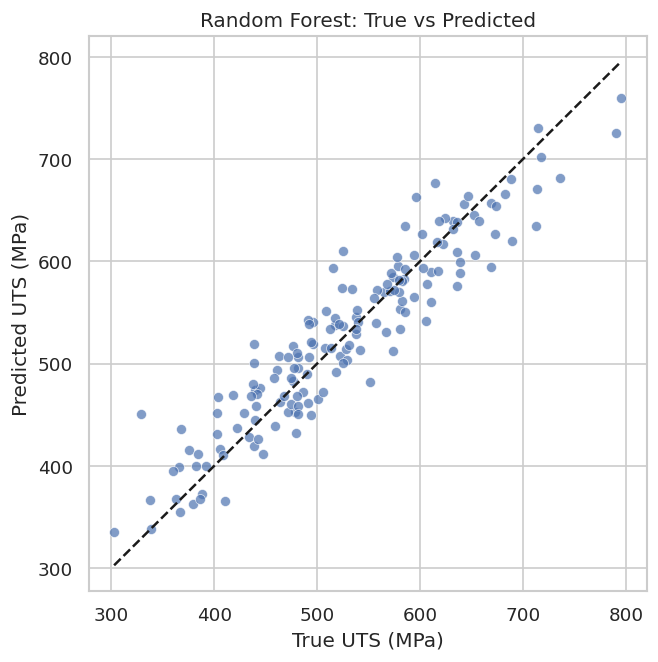

Top 12 feature importances:


,0
C_wt%,0.461504
GrainSize_um,0.212654
Temp_600,0.094516
CoolingRate_Cps,0.050821
Temp_200,0.048260
Temp_450,0.024267
Cr_wt%,0.020957
Si_wt%,0.017086
Mo_wt%,0.016559
Ni_wt%,0.012406


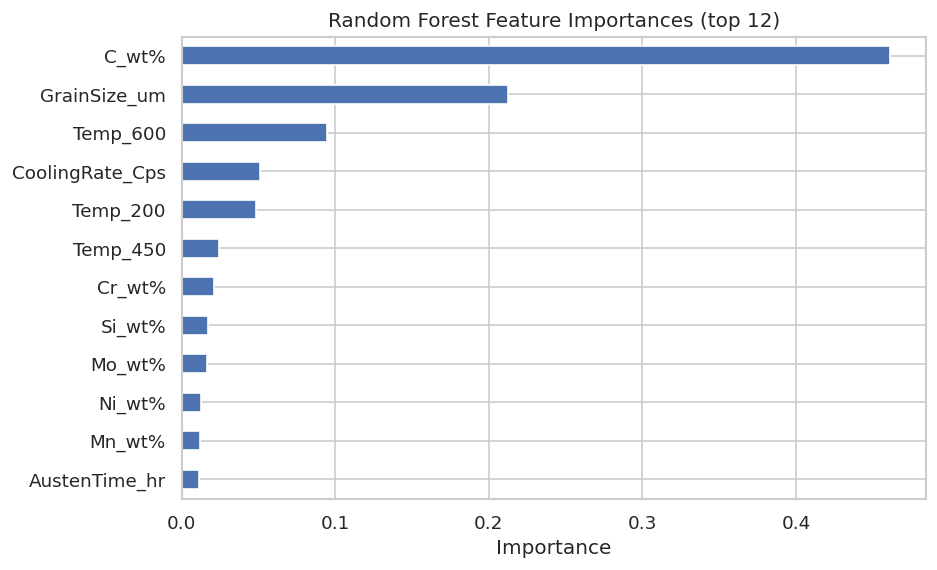

In [23]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print_regression_metrics(y_test, y_pred_rf, "RandomForest (default)")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True UTS (MPa)")
plt.ylabel("Predicted UTS (MPa)")
plt.title("Random Forest: True vs Predicted")
plt.show()

fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 12 feature importances:")
display(fi.head(12))

plt.figure(figsize=(8,5))
fi.head(12).sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importances (top 12)')
plt.xlabel('Importance')
plt.show()


In [25]:
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [6, 10, 15, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
rs = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist,
                        n_iter=12, cv=4, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_
y_pred_best = best_rf.predict(X_test)
print_regression_metrics(y_test, y_pred_best, "RandomForest (tuned)")


Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
RandomForest (tuned) -> MAE: 27.96 MPa, RMSE: 35.11 MPa, R2: 0.872


/tmp/ipython-input-2621482280.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


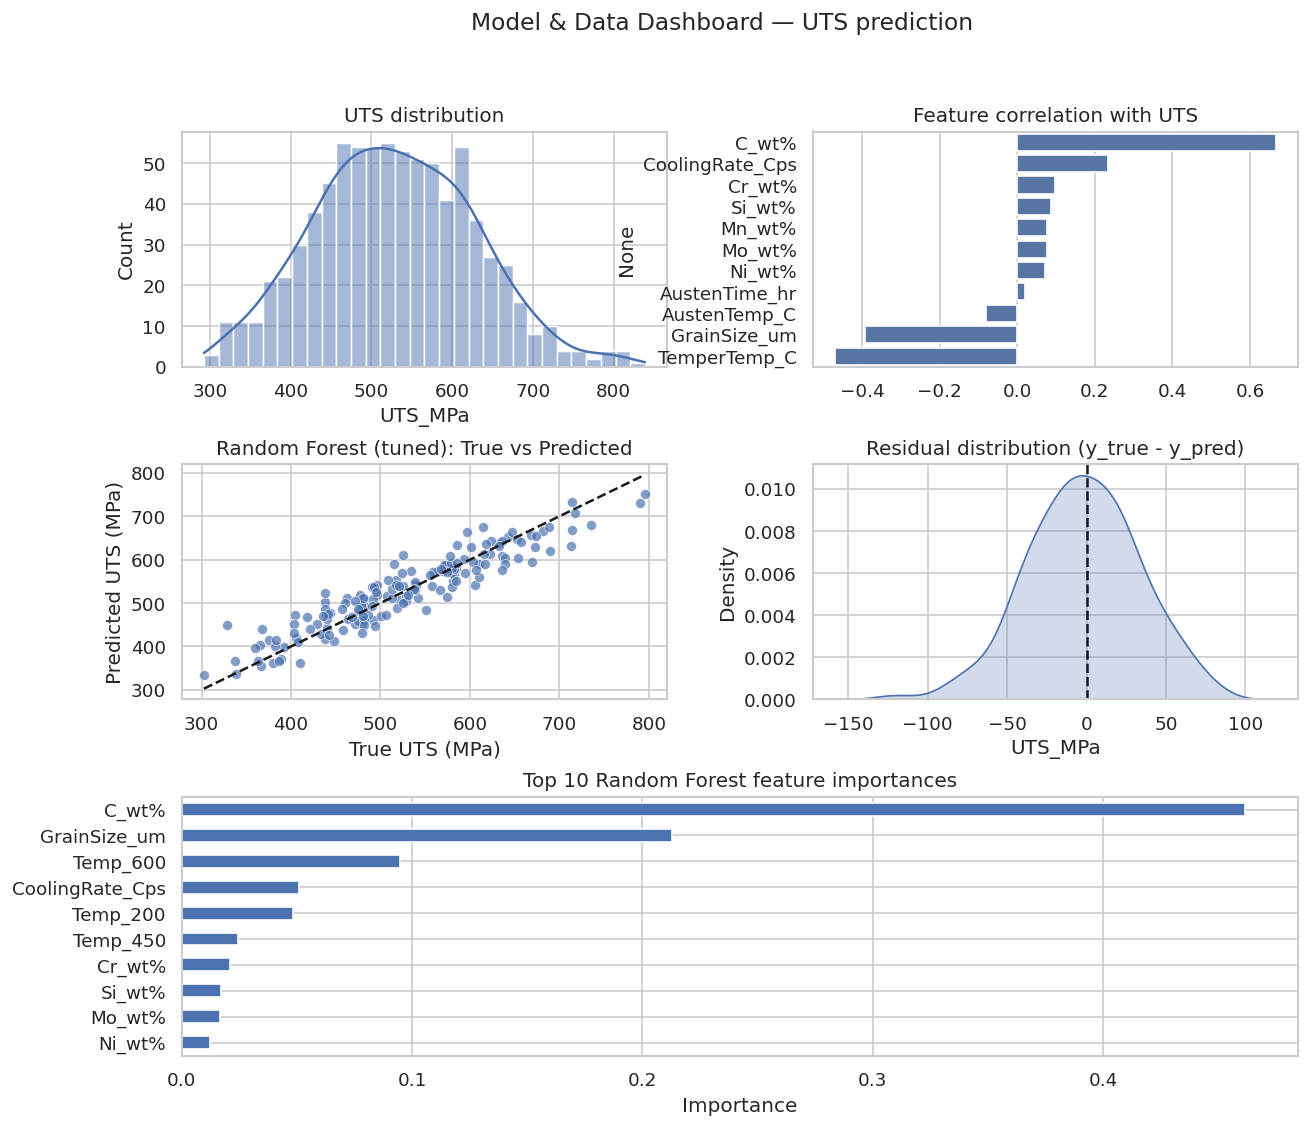

In [26]:
fig = plt.figure(constrained_layout=False, figsize=(12,10))
gs = fig.add_gridspec(3, 2, height_ratios=[1,1,1.1], hspace=0.4, wspace=0.3)

ax0 = fig.add_subplot(gs[0,0])
sns.histplot(df['UTS_MPa'], bins=30, kde=True, ax=ax0)
ax0.set_title("UTS distribution")

ax1 = fig.add_subplot(gs[0,1])
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, ax=ax1)
ax1.set_title("Feature correlation with UTS")

ax2 = fig.add_subplot(gs[1,0])
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7, ax=ax2)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax2.set_xlabel("True UTS (MPa)")
ax2.set_ylabel("Predicted UTS (MPa)")
ax2.set_title("Random Forest (tuned): True vs Predicted")

ax3 = fig.add_subplot(gs[1,1])
residuals = y_test - y_pred_best
sns.kdeplot(residuals, fill=True, ax=ax3)
ax3.axvline(0, color='k', linestyle='--')
ax3.set_title("Residual distribution (y_true - y_pred)")

ax4 = fig.add_subplot(gs[2,0:2])
topn = fi.head(10)
topn.sort_values().plot(kind='barh', ax=ax4)
ax4.set_title("Top 10 Random Forest feature importances")
ax4.set_xlabel("Importance")

plt.suptitle("Model & Data Dashboard — UTS prediction", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [27]:
# Uncomment if you installed shap in Step 1
"""
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)
top_feat = fi.index[0]
shap.dependence_plot(top_feat, shap_values, X_test, show=True)
"""
print("To use SHAP: install shap and uncomment the block above.")


To use SHAP: install shap and uncomment the block above.


In [28]:
joblib.dump(best_rf, 'best_rf_uts_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Saved best_rf_uts_model.joblib and scaler.joblib")

def predict_uts(sample_dict):
    tmp = pd.DataFrame([sample_dict])
    tmp = pd.get_dummies(tmp, columns=['TemperTemp_C'], prefix='Temp')
    for col in X_train.columns:
        if col not in tmp.columns:
            tmp[col] = 0
    tmp = tmp[X_train.columns]
    tmp.loc[:, numeric_cols] = scaler.transform(tmp[numeric_cols])
    pred = best_rf.predict(tmp)[0]
    return pred

# Example usage:
sample = {'C_wt%':0.45,'Si_wt%':0.6,'Mn_wt%':1.0,'Cr_wt%':0.2,'Ni_wt%':0.1,'Mo_wt%':0.02,
          'AustenTemp_C':900,'AustenTime_hr':1.0,'CoolingRate_Cps':50,'TemperTemp_C':350,'GrainSize_um':8.0}
print("Example predicted UTS (MPa):", predict_uts(sample))


Saved best_rf_uts_model.joblib and scaler.joblib
Example predicted UTS (MPa): 551.4334475000012


/tmp/ipython-input-1936875799.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02377278]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tmp.loc[:, numeric_cols] = scaler.transform(tmp[numeric_cols])
/tmp/ipython-input-1936875799.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.85482214]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tmp.loc[:, numeric_cols] = scaler.transform(tmp[numeric_cols])


In [29]:
tips = [
"Keep units identical: wt%, °C, μm, °C/s.",
"Add microstructure features if available (phase fractions, hardness).",
"For small real datasets (<200 samples) prefer simpler models or strong CV.",
"Split by batch if samples are correlated to avoid leakage.",
"Visualize residuals and predicted vs true to check biases."
]
for t in tips:
    print(t)


Keep units identical: wt%, °C, μm, °C/s.
Add microstructure features if available (phase fractions, hardness).
For small real datasets (<200 samples) prefer simpler models or strong CV.
Split by batch if samples are correlated to avoid leakage.
Visualize residuals and predicted vs true to check biases.
